# An introduction to `relatio` 
**Runtime $\sim$ 5min**

Original paper: ["Text Semantics Capture Political and Economic Narratives"](https://arxiv.org/abs/2108.01720)

----------------------------

This is a short demo of the package `relatio`.  It takes as input a text corpus and outputs a list of narrative statements. The pipeline is unsupervised: the user does not need to specify narratives beforehand. Narrative statements are defined as tuples of semantic roles with a (agent, verb, patient, attribute) structure. 

Here, we present the main wrapper functions to quickly obtain narrative statements from a corpus.

----------------------------

In this tutorial, we work with the Trump Tweet Archive corpus.

----------------------------

In [3]:
# Catch warnings for an easy ride
from relatio import FileLogger
logger = FileLogger(level = 'WARNING')

In [4]:
from relatio import load_data
df = load_data(dataset = "trump_tweet_archive", content = "raw")
df.head()

,id,doc
0,9.845497e+16,Republicans and Democrats have both created ou...
1,1.234653e+18,I was thrilled to be back in the Great city of...
2,1.304875e+18,The Unsolicited Mail In Ballot Scam is a major...
3,1.223641e+18,Getting a little exercise this morning!
4,1.215248e+18,Thank you Elise!


In [5]:
from relatio import Preprocessor

import spacy
nlp = spacy.load('en_core_web_md')
stop_words = list(nlp.Defaults.stop_words)

p = Preprocessor(
    spacy_model = "en_core_web_sm",
    remove_punctuation = True,
    remove_digits = True,
    lowercase = True,
    lemmatize = True,
    remove_chars = ["\"",'-',"^",".","?","!",";","(",")",",",":","\'","+","&","|","/","{","}",
                    "~","_","`","[","]",">","<","=","*","%","$","@","#","’"],
    stop_words = stop_words,
    n_process = -1,
    batch_size = 100
)

df = p.split_into_sentences(
    df, output_path = None, progress_bar = True
)

Splitting into sentences...


100%|██████████| 32323/32323 [00:34<00:00, 923.79it/s] 


In [6]:
from relatio import SRL

SRL = SRL(
    path = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz",
    batch_size = 10,
    cuda_device = -1
)

srl_res = SRL(df['sentence'][0:100], progress_bar=True)

Running SRL...


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


In [7]:
from relatio import load_data
srl_res = load_data('trump_tweet_archive', 'srl_res')

In [8]:
from relatio import extract_roles

roles, sentence_index = extract_roles(
    srl_res, 
    used_roles = ["ARG0","B-V","B-ARGM-NEG","B-ARGM-MOD","ARG1","ARG2"],
    progress_bar = True
)

for d in roles[0:5]: print(d)

Extracting semantic roles...


100%|██████████| 68616/68616 [00:02<00:00, 29796.54it/s]

{'B-V': 'have'}
{'ARG0': 'Republicans and Democrats', 'ARG1': 'our economic problems', 'B-V': 'created'}
{'ARG1': 'I', 'ARG2': 'thrilled to be back in the Great city of Charlotte , North Carolina with thousands of hardworking American Patriots who love our Country , cherish our values , respect our laws , and always put AMERICA FIRST', 'B-V': 'was'}
{'ARG1': 'I', 'ARG2': 'to be back in the Great city of Charlotte , North Carolina with thousands of hardworking American Patriots who love our Country , cherish our values , respect our laws , and always put AMERICA FIRST', 'B-V': 'thrilled'}
{'ARG1': 'I', 'ARG2': 'back in the Great city of Charlotte , North Carolina', 'B-V': 'be'}


In [9]:
postproc_roles = p.process_roles(roles, 
                                 dict_of_pos_tags_to_keep = {
                                     "ARG0": ['PRON', 'NOUN', 'PROPN'],
                                     "B-V": ['VERB'],
                                     "ARG1": ['NOUN', 'PROPN', 'PRON']
                                 }, 
                                 max_length = 50,
                                 progress_bar = True,
                                 output_path = 'postproc_roles.json')

for d in postproc_roles[0:5]: print(d)

Cleaning phrases for role ARG0...


100%|██████████| 49281/49281 [00:21<00:00, 2334.69it/s]


Cleaning phrases for role B-V...


100%|██████████| 135562/135562 [00:57<00:00, 2343.32it/s]


Cleaning phrases for role B-ARGM-MOD...


100%|██████████| 13752/13752 [00:05<00:00, 2329.86it/s]


Cleaning phrases for role ARG1...


100%|██████████| 88730/88730 [00:51<00:00, 1727.86it/s]


Cleaning phrases for role ARG2...


100%|██████████| 32132/32132 [00:19<00:00, 1640.89it/s]


{}
{'ARG0': 'republicans democrats', 'B-V': 'create', 'ARG1': 'problem'}
{}
{'B-V': 'thrill'}
{'ARG2': 'great city charlotte north carolina'}


In [10]:
from relatio.utils import load_roles
postproc_roles = load_roles('postproc_roles.json')

In [11]:
known_entities = p.mine_entities(
    df['sentence'], 
    clean_entities = True, 
    progress_bar = True,
    output_path = 'entities.pkl'
)

for n in known_entities.most_common(10): print(n)

Mining named entities...


100%|██████████| 63723/63723 [00:50<00:00, 1271.27it/s]


('democrats', 1153)
('china', 902)
('u s', 843)
('america', 585)
('american', 577)
('trump', 531)
('barackobama', 498)
('united states', 438)
('republicans', 437)
('republican', 418)


In [12]:
from relatio.utils import load_entities
known_entities = load_entities('entities.pkl')

top_known_entities = [e[0] for e in list(known_entities.most_common(100)) if e[0] != '']

In [13]:
from relatio.narrative_models import NarrativeModel

m = NarrativeModel(
    clustering = 'kmeans',
    PCA = True,
    UMAP = True,
    roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1', 'ARG2'],
    roles_with_known_entities = ['ARG0','ARG1','ARG2'],
    known_entities = top_known_entities,
    assignment_to_known_entities = 'character_matching',
    roles_with_unknown_entities = ['ARG0','ARG1','ARG2'],
    threshold = 0.3
)    
             
m.fit(postproc_roles, progress_bar = True) # pca_args, umap_args, and cluster_args give compete control to the user

2023-03-12 10:55:45.991568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-12 10:55:45.991601: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-12 10:55:45.991626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (izmir): /proc/driver/nvidia/version does not exist
2023-03-12 10:55:45.992714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Matching known entities (with character matching)...


100%|██████████| 8042/8042 [00:00<00:00, 8986.46it/s]


Matching known entities (with character matching)...


100%|██████████| 25267/25267 [00:02<00:00, 8924.81it/s]


Matching known entities (with character matching)...


100%|██████████| 15227/15227 [00:01<00:00, 8052.83it/s]


Computing phrase embeddings...


100%|██████████| 31552/31552 [01:18<00:00, 403.85it/s]


Dimension reduction via PCA...
PCA parameters:
{'n_components': 50, 'svd_solver': 'full'}
Dimension reduction via UMAP...
UMAP parameters:
{'n_neighbors': 15, 'n_components': 2, 'random_state': 0}
Clustering phrases into clusters...
Clustering parameters chosen in this range:
{'n_clusters': [31, 78, 157, 235, 315], 'random_state': 0}
Labeling the clusters by the most frequent phrases...


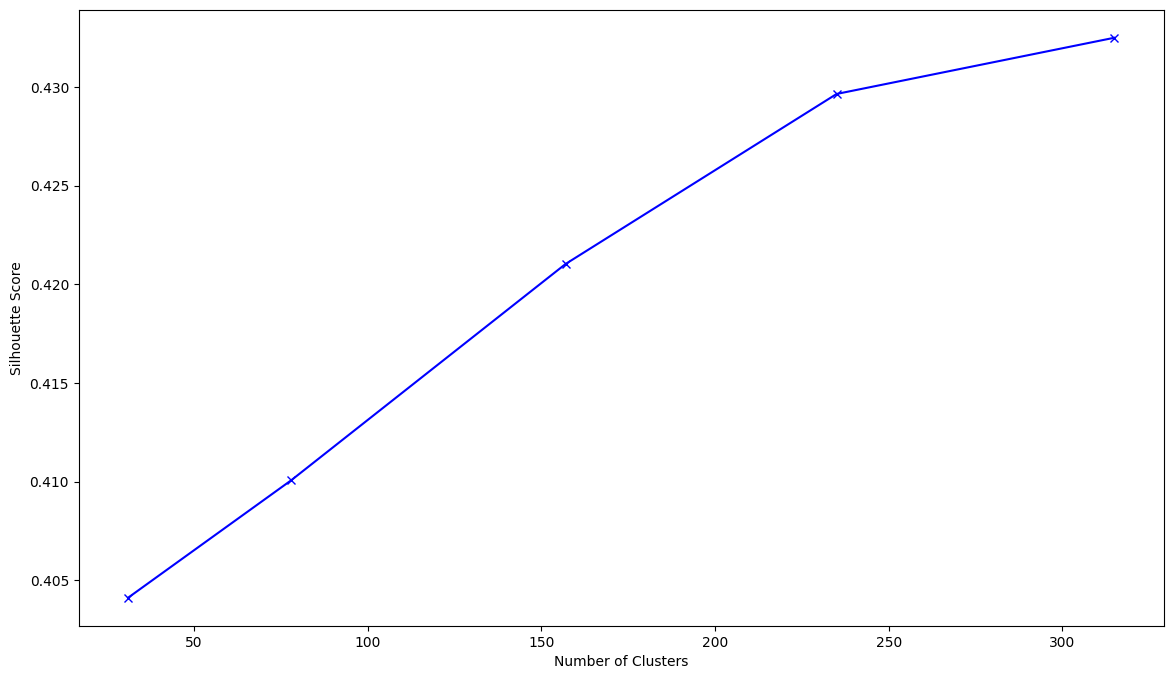

In [14]:
if m.clustering == 'kmeans':
    m.plot_selection_metric() # only for kmeans 

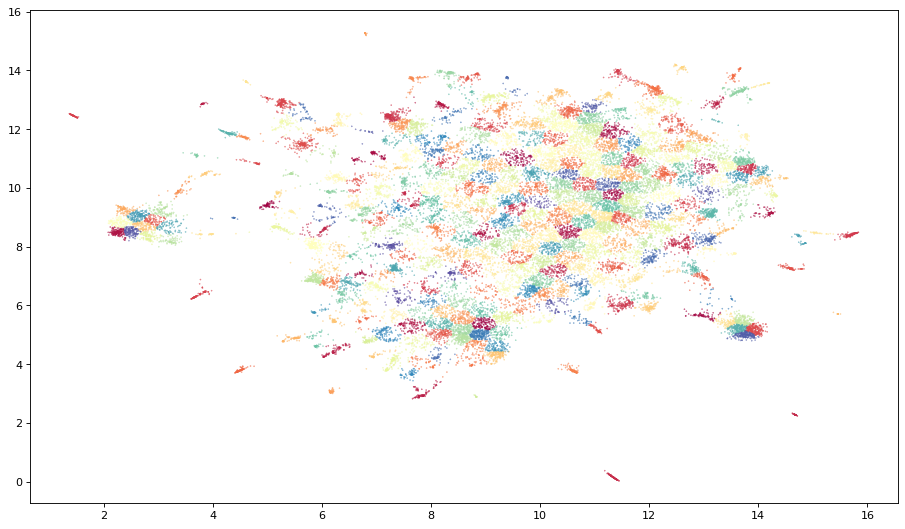

In [15]:
if m.umap_args['n_components'] == 2:
    m.plot_clusters('clusters.pdf') # only for UMAP with 2 components (the default)

In [16]:
m.labels_unknown_entities

{0: 'tom brady',
 1: 'conflict',
 2: 'corruption',
 3: 'dead',
 4: 'strzok',
 5: 'crazy',
 6: 'putin',
 7: 'ebola',
 8: 'service',
 9: 'friend',
 10: 'news',
 11: 'amp',
 12: 'general flynn',
 13: 'way',
 14: 'hurricane',
 15: 'fema',
 16: 'nancy pelosi',
 17: 'cruz',
 18: 'energy',
 19: 'macys',
 20: 'victory',
 21: 'collusion',
 22: 'judge',
 23: 'day',
 24: 'interview',
 25: 'world',
 26: 'beautiful',
 27: 'military',
 28: 'country',
 29: 'deal',
 30: 'voter',
 31: 'bill',
 32: 'enemy',
 33: 'unemployment',
 34: 'taxis',
 35: 'impeachment',
 36: 'public',
 37: 'immigration',
 38: 'debt',
 39: 'second amendment',
 40: 'jebbush',
 41: 'crime',
 42: 'information',
 43: 'police',
 44: 'chief staff',
 45: 'campaign',
 46: 'protester',
 47: 'repeal amp replace',
 48: 'john',
 49: 'trade',
 50: 'business',
 51: 'card',
 52: 'damage',
 53: 'team',
 54: 'libya',
 55: 'a g',
 56: 'rnc',
 57: 'bad',
 58: 'boeing',
 59: 'golf',
 60: 'time',
 61: 'john mccain',
 62: 'wind turbine',
 63: 'law',
 

In [17]:
m.inspect_cluster(label = 'radical left')

[('radical left', 51),
 ('radical', 8),
 ('radical islam', 4),
 ('radical left congresswomen', 4),
 ('funding radical ideology', 2),
 ('radical left crime cancel culture', 2),
 ('radical left lamestream media', 2),
 ('radical left magazine', 2),
 ('statement radical left congresswomen', 2),
 ('answer radical left justices', 1)]

In [18]:
m.clusters_to_txt()

In [19]:
narratives = m.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Matching known entities (with character matching)...


100%|██████████| 24681/24681 [00:02<00:00, 9729.82it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|██████████| 24681/24681 [01:03<00:00, 389.57it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...
Assigning labels to matches...

Predicting entities for role: ARG1...
Matching known entities (with character matching)...


100%|██████████| 61466/61466 [00:05<00:00, 10488.53it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|██████████| 61466/61466 [02:32<00:00, 402.17it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...
Assigning labels to matches...

Predicting entities for role: ARG2...
Matching known entities (with character matching)...


100%|██████████| 26765/26765 [00:02<00:00, 9457.40it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|██████████| 26765/26765 [01:06<00:00, 401.18it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...
Assigning labels to matches...


In [24]:
from relatio.utils import prettify_narratives
pretty_narratives = prettify_narratives(narratives, fix_grammar=False)
for t in pretty_narratives.most_common(10): print(t)

('interview discuss barackobama', 15)
('democrats want open borders', 8)
('china want deal', 8)
('democrats commit crime', 7)
('interview discuss gop', 6)
('china steal job', 6)
('interview discuss mittromney', 6)
('interview discuss obama', 5)
('strong require question', 5)
('dollar kill country', 5)


In [ ]:
from relatio import build_graph, draw_graph

G = build_graph(
    narratives, 
    top_n = 100, 
    prune_network = True
)

draw_graph(
    G,
    notebook = False,
    show_buttons = False,
    width="1600px",
    height="1000px",
    output_filename = 'network_of_narratives.html'
    )